In [2391]:
import numpy as np
import pandas as pd
import os
import pickle
import sys
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import PolynomialFeatures
sys.path.append('/Users/ramtinyazdanian/PycharmProjects/job_skill_trend_analysis/')
from utilities.common_utils import *
from utilities.analysis_utils import *
from utilities.pandas_utils import *
%matplotlib inline
%load_ext autoreload
%autoreload 2
from scipy.stats import shapiro, anderson, probplot
from scipy import stats

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [242]:
root_data_path = '/Users/ramtinyazdanian/Downloads/jobtech/'
all_filenames = os.listdir(root_data_path)
all_dataframes = [pd.read_csv(os.path.join(root_data_path,filename)) 
                  for filename in all_filenames if filename[-3:] == 'csv' and filename[0] != '~']

In [243]:
df_all = pd.concat(all_dataframes)

In [244]:
df_all.head()

,jobId,jobUrl,jobTitle,jobDescription,datePosted,companyId,companyName,industryId,yoxMin,yoxMax,finalWageMin,finalWageMax,countryCode,skills,qualifications
0,0023502d439415ad8bbdb62a7020114c0e67ed5824e0b6...,https://sg.jobsdb.com/job/rd/adbd75e33b3a1415d...,Admin & Accounts Executive,Roles &amp; ResponsibilitiesJob Description<br...,2020-01-01,4a536df3d73f2123c14b4a1d5fa6b8ecfd9352b3c390f1...,MILWORKS SOLUTIONS PTE. LTD.,InfoComm Technologies,0,0,1150.0,1917.0,SG,"[{'skill': 'accounts payable accounting', 'ski...",['Bachelors']
1,0053799fde5277b3ee431bb57f0820ef01a4c6abf7246d...,https://sg.jobsdb.com/job/rd/adbd75e33b3a1415d...,Admin & Accounts Executive,Roles &amp; ResponsibilitiesJob Description<br...,2020-01-01,4a536df3d73f2123c14b4a1d5fa6b8ecfd9352b3c390f1...,MILWORKS SOLUTIONS PTE. LTD.,InfoComm Technologies,0,0,1150.0,1917.0,SG,"[{'skill': 'accounts payable accounting', 'ski...",['Bachelors']
2,009bd6514108fed114208aa85c28a2c318291978e301ee...,https://sg.jobsdb.com/job/rd/adbd75e33b3a1415d...,Admin & Accounts Executive,Roles &amp; ResponsibilitiesJob Description<br...,2020-01-01,4a536df3d73f2123c14b4a1d5fa6b8ecfd9352b3c390f1...,MILWORKS SOLUTIONS PTE. LTD.,InfoComm Technologies,0,0,1150.0,1917.0,SG,"[{'skill': 'accounts payable accounting', 'ski...",['Bachelors']
3,00edb53a28e215cfb3f8d90594fac0872919bba772d842...,https://sg.jobsdb.com/job/rd/adbd75e33b3a1415d...,Admin & Accounts Executive,Roles &amp; ResponsibilitiesJob Description<br...,2020-01-01,4a536df3d73f2123c14b4a1d5fa6b8ecfd9352b3c390f1...,MILWORKS SOLUTIONS PTE. LTD.,InfoComm Technologies,0,0,1150.0,1917.0,SG,"[{'skill': 'accounts payable accounting', 'ski...",['Bachelors']
4,01103f9a143bdecf5e09484315bd1a2fb36fe9e7acbca6...,https://sg.jobsdb.com/job/rd/adbd75e33b3a1415d...,Admin & Accounts Executive,Roles &amp; ResponsibilitiesJob Description<br...,2020-01-01,4a536df3d73f2123c14b4a1d5fa6b8ecfd9352b3c390f1...,MILWORKS SOLUTIONS PTE. LTD.,InfoComm Technologies,0,0,1150.0,1917.0,SG,"[{'skill': 'accounts payable accounting', 'ski...",['Bachelors']


In [245]:
df_all.industryId.unique()

array(['InfoComm Technologies'], dtype=object)

In [246]:
df_all_useful_cols = df_all[['companyName', 'industryId', 'datePosted', 'skills']].rename(columns={
    'companyName': 'Company', 'industryId': 'Industry', 'datePosted': 'Date', 'skills': 'Skill List'
})

df_all_useful_cols['Skill List'] = df_all_useful_cols['Skill List'].apply(eval)
df_all_useful_cols['Date'] = pd.to_datetime(df_all_useful_cols['Date'])
company_totals = divide_into_periods(df_all_useful_cols, ['Company'], result_col_name='Total')

df_all_useful_cols = explode(df_all_useful_cols, ['Skill List'])
df_all_useful_cols = df_all_useful_cols.loc[df_all_useful_cols['Skill List'].apply(lambda x: x != '')]

df_all_useful_cols['Skill'] = df_all_useful_cols['Skill List'].apply(lambda x: x['skill'])
df_all_useful_cols['Skill Type'] = df_all_useful_cols['Skill List'].apply(lambda x: x['skillTypeId'])
df_all_useful_cols = df_all_useful_cols.drop(columns='Skill List')

In [247]:
df_all_useful_cols.head()

,Company,Date,Industry,Skill,Skill Type
0,MILWORKS SOLUTIONS PTE. LTD.,2020-01-01,InfoComm Technologies,accounts payable accounting,2
1,Red Hat,2018-01-01,InfoComm Technologies,virtualization technology,1
2,KEYREPLY PTE. LTD.,2019-01-03,InfoComm Technologies,account management,2
3,KEYREPLY PTE. LTD.,2019-01-03,InfoComm Technologies,business development,1
4,KEYREPLY PTE. LTD.,2019-01-03,InfoComm Technologies,communication,4


In [420]:
company_totals.sum()

Company    01 Computer System Pte Ltd01 Computer System P...
Total                                                  37413
dtype: object

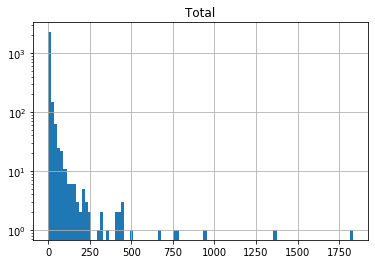

In [425]:
company_totals.groupby('Company').sum().hist(bins=100)
plt.yscale('log')

In [427]:
company_totals['year'] = company_totals.Date.apply(lambda x: x.year)
company_totals.groupby('year').sum()

,Total
year,
2017,4516
2018,9915
2019,17835
2020,5147


If we want to filter out the irrelevant skill types (which I need to figure out), here is the place.

In [248]:
df_all_useful_cols['Skill Type'].unique()

array([2, 1, 4, 3])

In [249]:
df_all_useful_cols.loc[df_all_useful_cols['Skill Type'] == 1].groupby('Skill').count().\
            sort_values('Date', ascending=False).index.values.tolist()

['computer science',
 'cloud technology',
 'regulatory compliance',
 'sops/best practices',
 'consulting',
 'unix/linux',
 'hardware',
 'information technology',
 'business finance',
 'business development',
 'microsoft windows os',
 'web services',
 'social media (facebook)',
 'legal/law',
 'computer engineering',
 'data center',
 'telecommunications',
 'social media',
 'healthcare',
 'operating systems',
 'supply chain & logistics',
 'scrum/agile',
 'amazon web services',
 'information systems',
 'e-commerce',
 'virtualization technology',
 'web applications',
 'sdlc',
 'advertising',
 'software-as-a-service (saas)',
 'investment',
 'open source technology',
 'vmware',
 'manufacturing',
 'system engineering',
 'genetic information',
 'continuous improvement',
 'human resource development',
 'b2b engagement',
 'business administration',
 'machine learning algorithms',
 'compensation & benefits',
 'artificial intelligence',
 'iso',
 'big data',
 'marketing strategy',
 'cyber security',

Skill type 3 is languages and licenses, 4 is general soft skills.

Types 1 and 2 are both hard skills, the difference being that type 1 deals with more generic skills and with clusters, while 2 deals with specific technology for the most part.

In [250]:
absolute_start = np.datetime64('2017-01-01')
absolute_end = np.datetime64('2020-01-01')

In [251]:
it_skills = set(pd.read_csv('./it_skills.csv').Skill.values)

In [252]:
it_skills

{'apache ibatis',
 'universal mobile telecommunications service (umts)',
 'network administration',
 'bluetooth',
 'flask (python)',
 'testng',
 'control-m',
 'backbone.js',
 'oracle database',
 'sap sd',
 'invision',
 'mailchimp',
 'anti-spam programming',
 'sdk',
 'continuous improvement',
 'scip',
 'togaf',
 'automation solution',
 'standard template library (c++)',
 'macromedia dreamweaver',
 'numpy',
 'online banking',
 'logical architecture',
 'video processing',
 'travis ci',
 'project management',
 'quantum computing',
 'publishing',
 'mes (manufacturing execution system)',
 'service oriented architecture',
 'microsoft office 365',
 'xsl',
 'ibm infosphere datastage',
 'webpack',
 'blockchain technology',
 'caffe',
 'xamarin',
 'interaction design (ixd)',
 'zigbee',
 'c',
 'dynamic host configuration protocol',
 'google bigtable',
 'wi-fi protected setup',
 'logstash',
 'apache spark',
 'customer relationship management',
 'apache struts',
 'bigquery',
 'financial audit',
 'roo

In [253]:
skills_df = divide_into_periods(df_all_useful_cols.loc[(df_all_useful_cols['Skill Type'] == 1) | 
                                                       (df_all_useful_cols['Skill Type'] == 2)], 
                                ['Company', 'Skill'], 
                                absolute_start, absolute_end, result_col_name='Job Postings Raw')
skills_df = pd.merge(skills_df, company_totals, on = ['Company', 'Date'])
skills_df['Job Postings'] = skills_df['Job Postings Raw'] / skills_df['Total']
skills_df = skills_df.loc[skills_df.Skill.apply(lambda x: x in it_skills)]

In [254]:
skills_df.sort_values('Date').head(10)

,Company,Skill,Date,Job Postings Raw,Total,Job Postings
175670,Sapura Synergy Singapore Pte Ltd,microsoft windows os,2017-01-01,2,3,0.666667
7127,ARETE M PTE. LTD.,vmware,2017-01-01,1,3,0.333333
189852,Tivo Technologies Pte Ltd,virtual private network,2017-01-01,1,1,1.000000
189853,Tivo Technologies Pte Ltd,wide area network configuration,2017-01-01,1,1,1.000000
179320,Solarwinds Software Asia Pte Ltd,general algorithms,2017-01-01,1,7,0.142857
189122,Third Sight Pte Ltd,swot analysis,2017-01-01,1,2,0.500000
189120,Third Sight Pte Ltd,project management,2017-01-01,1,2,0.500000
189115,Third Sight Pte Ltd,multi-task,2017-01-01,1,2,0.500000
189113,Third Sight Pte Ltd,economics,2017-01-01,1,2,0.500000
7126,ARETE M PTE. LTD.,version control,2017-01-01,1,3,0.333333


In [255]:
len(skills_df.Skill.unique())

1021

In [256]:
# skills_df[['Skill']].drop_duplicates().sort_values('Skill').to_csv('./all_skills.csv')

## Computing the true emerging skills

In [257]:
monthly_totals = compute_total_values(skills_df)
total_log = compute_total_log_mean(skills_df)

In [1600]:
start_and_end_dates = [(np.datetime64('2017-01-01'), np.datetime64('2018-01-01')),
                       (np.datetime64('2018-01-01'), np.datetime64('2019-01-01')), 
                       (np.datetime64('2019-01-01'), np.datetime64('2020-01-01')),
                       (np.datetime64('2018-01-01'), np.datetime64('2020-01-01')),
                       (np.datetime64('2017-01-01'), np.datetime64('2019-01-01')),
                       (np.datetime64('2017-01-01'), np.datetime64('2020-01-01'))]

# start_and_end_dates = [(np.datetime64('2017-01-01'), np.datetime64('2018-01-01')), 
#                        (np.datetime64('2017-01-01'), np.datetime64('2019-01-01')), 
#                        (np.datetime64('2018-01-01'), np.datetime64('2019-01-01')), 
#                        (np.datetime64('2019-01-01'), np.datetime64('2020-01-01')),
#                        (np.datetime64('2018-01-01'), np.datetime64('2020-01-01')),
#                        (np.datetime64('2017-01-01'), np.datetime64('2020-01-01'))]

total_values = [get_period_of_time(monthly_totals, start_and_end_dates[i][0], start_and_end_dates[i][1]).sum()[0]
                for i in range(len(start_and_end_dates))]

In [1925]:
skill_trends = [logsum_trend_slope_wrapper(skills_df, 
                                                  start_and_end_dates[i][0], start_and_end_dates[i][1],
                                                  total_log, nologtest=False, smoothing='exp', degree=2) 
                                for i in range(len(start_and_end_dates))]

Start: 2017-01-01
End: 2018-01-01
Number of skills: 708
            Slope   Intercept  Acceleration   Spikiness
count  708.000000  708.000000    708.000000  708.000000
mean    -0.104055    1.295287      0.011941    1.036928
std      0.309411    3.506358      0.030898   14.736284
min     -2.612408   -0.444699     -0.083190 -115.701042
25%     -0.184569   -0.159264     -0.002022   -0.705308
50%     -0.078208    0.096534      0.006005    0.103336
75%      0.011954    0.967769      0.017922    1.949283
max      1.218689   29.879016      0.336703  214.518992
Start: 2018-01-01
End: 2019-01-01
Number of skills: 875
            Slope   Intercept  Acceleration   Spikiness
count  875.000000  875.000000    875.000000  875.000000
mean    -0.290111    2.634137      0.034484    1.009805
std      0.639499    7.034259      0.073130   18.164607
min     -6.459655   -0.592287     -0.065477 -123.195518
25%     -0.310690   -0.157633      0.002753   -0.247942
50%     -0.151261    0.292140      0.014941    1

In [1926]:
skill_trends[2].corr(method='pearson')

,Slope,Intercept,Acceleration,Spikiness,Job Postings Raw
Slope,1.000000,0.801890,-0.976018,-0.000258,0.892240
Intercept,0.801890,1.000000,-0.784157,-0.001733,0.962996
Acceleration,-0.976018,-0.784157,1.000000,-0.003283,-0.849529
Spikiness,-0.000258,-0.001733,-0.003283,1.000000,-0.003569
Job Postings Raw,0.892240,0.962996,-0.849529,-0.003569,1.000000


In [1927]:
skill_trends[2].corr(method='spearman')

,Slope,Intercept,Acceleration,Spikiness,Job Postings Raw
Slope,1.000000,0.305052,-0.934016,0.182646,0.602959
Intercept,0.305052,1.000000,-0.299176,0.376972,0.873706
Acceleration,-0.934016,-0.299176,1.000000,-0.158925,-0.543534
Spikiness,0.182646,0.376972,-0.158925,1.000000,0.463944
Job Postings Raw,0.602959,0.873706,-0.543534,0.463944,1.000000


In [2254]:
def remove_outliers(s):
#     return s.loc[(s<s.mean()+10*s.std()) & (s>s.mean()-10*s.std())]
    return s

In [2346]:
def get_hybrid_score(df, cols, weights=None):
    if weights is None:
        weights = [1]*len(cols)
    return sum([weights[i]*np.log(1+(df[cols[i]] - remove_outliers(df[cols[i]]).min())/
                                  (remove_outliers(df[cols[i]]).max()-
                                   remove_outliers(df[cols[i]]).min()))
                if df[cols[i]].max() - df[cols[i]].min() > 0 else 0
                for i in range(len(cols)) ])

for skill_trend_df in skill_trends:
    skill_trend_df['HybridScore'] = get_hybrid_score(skill_trend_df, 
                                 ['Slope', 'Acceleration'], weights=[1,1])

In [2347]:
emerging_skills = [threshold_logsum_trends_simple(skill_trends[i], total=total_values[i], col='HybridScore', 
                                                  only_positives=True,
                                                  col_percentile_thresh=.75, pop_lower=0.001, pop_upper=0.01) 
                        for i in range(len(skill_trends))]

In [2348]:
emerging_skills[2]

,Skill,Slope,Intercept,Acceleration,Spikiness,Job Postings Raw,HybridScore
0,adobe creative suite,0.588009,0.197755,-0.037735,1.822395,55,0.747092
1,adobe premiere pro,0.151118,0.352654,0.000980,1.938555,39,0.740678
2,anti-virus programming,0.260726,2.969967,-0.003238,1.664041,109,0.744494
3,apache hbase,0.819212,0.001151,-0.066767,1.908924,57,0.746803
4,apache kafka,0.718966,3.142010,-0.062423,1.384168,106,0.743681
5,apache struts,0.609461,0.965132,-0.037668,1.373857,73,0.748165
6,apache tomcat,0.718819,2.168427,-0.044365,1.547311,106,0.750842
7,asp,0.967188,0.544443,-0.074736,1.649945,68,0.750739
8,biometrics,0.523930,0.100611,-0.033793,1.917402,62,0.745511
9,biotechnology,0.692009,-0.174502,-0.044687,2.183153,59,0.749412


In [2349]:
compare_emerging_skill_sets(emerging_skills, start_and_end_dates, sort_type='score', sort_col='Slope')


Comparing 2017-01-01 to 2018-01-01 with 2018-01-01 to 2019-01-01

# of skills shared and exclusive to each date (in order)
24 64 73

The skills themselves:

Shared:

['bgp (border gateway protocol)', 'mpls', 'github', 'it service management', 'ospf', 'data wrangling', 'google adwords', 'powershell', 'oracle database', 'data loss prevention', 'service oriented architecture', 'dynamic host configuration protocol', 'it operations management (itom)', 'financial analysis', 'mongodb', 'soap', 'predictive modelling', 'google go programming language', 'benchmarking', 'ruby', 'ibm websphere', 'jboss', 'infrastructure-as-a-service (iaas)', 'micro-services']

Exclusive to 2017-01-01 to 2018-01-01

['data center operations', 'system testing', 'uml', 'load balancer', 'relational database', 'microsoft hyper-v', 'nas infrastructure', 'linq', 'solution design', 'docker', 'geographic information system (gis)', 'mvc framework', 'database marketing', 'apache struts', 'source code', 'laravel', 'jenkins',

# of skills shared and exclusive to each date (in order)
29 59 75

The skills themselves:

Shared:

['system testing', 'bgp (border gateway protocol)', 'mpls', 'github', 'it service management', 'source code', 'animation', 'data wrangling', 'powershell', 'openstack', 'oracle database', 'application security design', 'service oriented architecture', 'encryption/cryptography', 'splunk', 'dynamic host configuration protocol', 'penetration testing', 'financial analysis', 'confluence', 'mongodb', 'soap', 'knowledge management', 'practical malware analysis', 'ibm db2', 'google go programming language', 'benchmarking', 'ruby', 'ibm websphere', 'infrastructure-as-a-service (iaas)']

Exclusive to 2017-01-01 to 2018-01-01

['data center operations', 'uml', 'load balancer', 'relational database', 'microsoft hyper-v', 'nas infrastructure', 'linq', 'solution design', 'docker', 'geographic information system (gis)', 'mvc framework', 'ospf', 'database marketing', 'apache struts', 'laravel', 'jenkins'

# of skills shared and exclusive to each date (in order)
59 38 45

The skills themselves:

Shared:

['mpls', 'soap', 'bgp (border gateway protocol)', 'data quality control', 'dynamic host configuration protocol', 'postgresql', 'full stack development', 'infrastructure-as-a-service (iaas)', 'data wrangling', 'oracle database', 'swift', 'financial analysis', 'it service management', 'data/text mining', 'fintech', 'enterprise web architecture', 'github', 'mongodb', 'apache kafka', 'google analytics', 'process optimisation', 'natural language processing (nlp)', 'social media (youtube)', 'service management', 'quantitative analysis', 'financial audit', 'blockchain technology', 'openshift', 'data visualisation', 'vb', 'powershell', 'shell scripts', 'ibm websphere', 'content delivery network (cdn)', 'sas', 'pl/sql', 'matlab', 'wireframes', 'market analysis', 'business intelligence (bi) tools', 'qlikview', 'google go programming language', 'mac os', 'aml/cft', 'terraform', 'restful api', 'serv

### Evaluating the sets of trending skills based on known (and obvious) ground truth

In [2370]:
ground_truth_base = pd.DataFrame({'Skill': 
                    ['vue.js', 'deep learning', 'tensorflow', 'kubernetes', 'graphql',
                     'cryptocurrency', 'google go programming language', 'encryption/cryptography',
                     'redux', 'apache kafka', 'salesforce', 'aws lambda', 'amazon redshift', 'domo',
                     'data lakes', 'serverless computing', 'blockchain technology', 'amazon aurora', 
                     'docker', 'looker', 'autonomous cars', 'fintech', 'micro-services',
                     'data visualisation', 'apache hive', 'hadoop distributed file system', 
                     'apache flume', 'apache kafka', 'keras', 'predictive analytics',
                     'predictive modelling',
                     ]})

In [2371]:
def find_nonexistent_skills(skills_to_find, skills_to_search_in):
    skills_to_find_list = skills_to_find.Skill.values
    results = list()
    for skill in skills_to_find_list:
        if skill not in skills_to_search_in.index.values:
            results.append(skill)
    print(results)
    return results, skills_to_find.loc[skills_to_find.Skill.apply(lambda x: x not in results)]

In [2372]:
whatever, ground_truth_base = find_nonexistent_skills(ground_truth_base, pd.concat(skill_trends))

['aws lambda', 'domo', 'data lakes', 'serverless computing', 'amazon aurora', 'looker', 'autonomous cars']


In [2373]:
compute_prec_recall(emerging_skills[0], ground_truth_base)

{'micro-services', 'google go programming language', 'predictive modelling', 'docker', 'encryption/cryptography'}
5 88 24


(0.056818181818181816, 0.20833333333333334, 0.08928571428571429)

In [2374]:
compute_prec_recall(emerging_skills[1], ground_truth_base)

{'cryptocurrency', 'predictive analytics', 'fintech', 'micro-services', 'apache kafka', 'google go programming language', 'predictive modelling', 'kubernetes', 'blockchain technology', 'apache hive', 'data visualisation'}
11 97 24


(0.1134020618556701, 0.4583333333333333, 0.18181818181818182)

In [2375]:
compute_prec_recall(emerging_skills[2], ground_truth_base)

{'tensorflow', 'deep learning', 'encryption/cryptography', 'apache kafka'}
4 106 24


(0.03773584905660377, 0.16666666666666666, 0.06153846153846154)

In [2376]:
compute_prec_recall(emerging_skills[3], ground_truth_base)

{'apache kafka', 'tensorflow', 'encryption/cryptography', 'vue.js', 'keras', 'data visualisation'}
6 102 24


(0.058823529411764705, 0.25, 0.09523809523809523)

In [2377]:
compute_prec_recall(emerging_skills[4], ground_truth_base)

{'cryptocurrency', 'fintech', 'tensorflow', 'redux', 'deep learning', 'encryption/cryptography'}
6 101 24


(0.0594059405940594, 0.25, 0.096)

In [2378]:
compute_prec_recall(emerging_skills[5], ground_truth_base)

{'fintech', 'apache kafka', 'tensorflow', 'google go programming language', 'deep learning', 'vue.js', 'kubernetes', 'blockchain technology', 'apache hive', 'encryption/cryptography', 'data visualisation'}
11 104 24


(0.10576923076923077, 0.4583333333333333, 0.17187499999999997)

Now all of them combined:

In [2379]:
compute_prec_recall(pd.concat(emerging_skills), ground_truth_base)

{'cryptocurrency', 'predictive analytics', 'fintech', 'micro-services', 'apache kafka', 'tensorflow', 'google go programming language', 'redux', 'deep learning', 'predictive modelling', 'vue.js', 'keras', 'docker', 'kubernetes', 'blockchain technology', 'apache hive', 'encryption/cryptography', 'data visualisation'}
18 266 24


(0.06766917293233082, 0.75, 0.12413793103448274)

Takeaways here:

* Acceleration only seems to work for shorter time periods, since in the longer term, the growth of most skills (understandably) slows down. However, when all skills have low values in a period (due to generally low ad volumes), Acceleration once more becomes important.
* Velocity (Slope) is usually a good measure because it shows how much the skill has been growing. Its performance, however, changes based on whether we fit a 1st degree or a 2nd degree polynomial, and when values are generally low, it seems to do badly when it's a 2nd degree. It generally performs pretty well for longer periods, however.
* Spikiness is a mixed bag, but its observed linear independence from Velocity could prove helpful.
* If we fit higher degree polynomials (>=2) to the data, then we need to factor in _all_ the coefficients, and not just the Velocity or Acceleration, because if we only factor in one of them, we're at the mercy of that one's shortcomings.
* For now, the hybrid of Velocity and Acceleration seems to work in the most consistent fashion.

In [1856]:
skills_df.loc[skills_df.Skill.apply(lambda x: 'salesforce' in x)].Skill.unique()

array(['salesforce'], dtype=object)

### Looking at a few skills

In [2311]:
skill_trends[1].loc['apache kafka']

Slope               -0.128514
Intercept            0.890889
Acceleration         0.028011
Spikiness            2.483741
Job Postings Raw    41.000000
HybridScore          0.727428
Name: apache kafka, dtype: float64

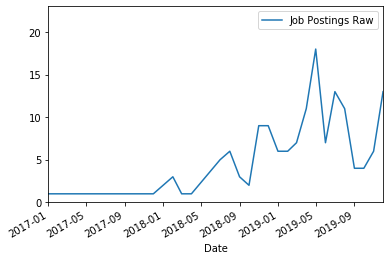

In [2314]:
df_to_plot = skills_df.loc[skills_df.Skill == 'apache kafka', ['Date', 'Job Postings Raw']].groupby('Date').sum()
df_to_plot.plot()
plt.ylim([0, df_to_plot['Job Postings Raw'].max() + 5])
plt.show()

## Looking at the distributions of computed quantities

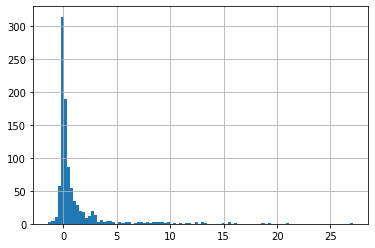

In [872]:
skill_trends[1].Slope.hist(bins=100)
#plt.yscale('log')

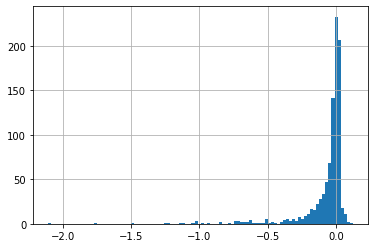

In [875]:
skill_trends[1].Acceleration.hist(bins=100)
#plt.yscale('log')

In [876]:
skill_trends[2].Slope.quantile(.8), \
            skill_trends[2].Slope.quantile(.9), skill_trends[2].Slope.mean() 

(0.37241409584174945, 0.9372103281023969, 0.30903529177787625)

Interestingly, as this plot and the summary statistics show, the Slope values are way more skewed to the right here, and the Generalised Normals that we had used before will fail.

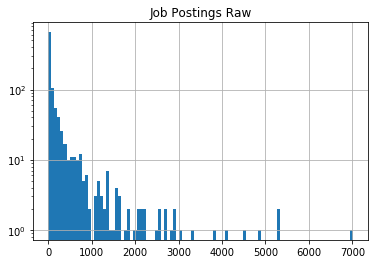

In [877]:
skills_df[['Skill', 'Job Postings Raw']].groupby('Skill').sum().\
                        hist(bins = 100)
plt.yscale('log')

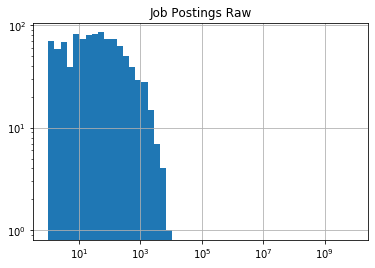

In [878]:
skills_df[['Skill', 'Job Postings Raw']].groupby('Skill').sum().\
                        hist(bins = np.logspace(np.log(1), np.log(20000), 50))
plt.yscale('log')
plt.xscale('log')

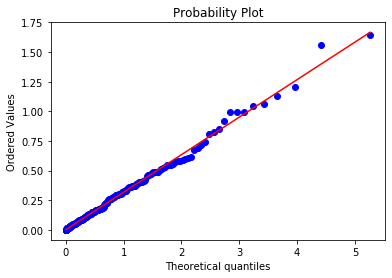

In [894]:
probplot(skill_trends[0].loc[skill_trends[0].Slope > 0].Slope.values, dist=stats.gamma, 
         sparams=(.8), fit=True, plot=plt)
plt.show()

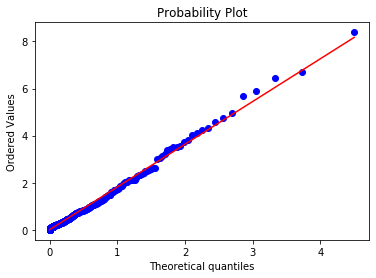

In [885]:
probplot(skill_trends[2].loc[skill_trends[2].Slope > 0].Slope.values, dist=stats.gamma, 
         sparams=(.3), fit=True, plot=plt)
plt.show()

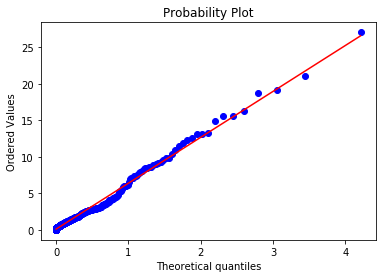

In [895]:
probplot(skill_trends[1].loc[skill_trends[1].Slope > 0].Slope.values, dist=stats.gamma, 
         sparams=(.25), fit=True, plot=plt)
plt.show()

Generally, it's safe to say that the slope values generally follow two back to back Gamma distributions, one for the positives and one for the negatives. We don't really care about the negatives (because they're the _declining_ skills, while we're only interested in the growing skills), meaning that we can just discard the negatives and fit a Gamma to the positives.

The mean and variance of this distribution are equal to the shape parameter, which makes it very interesting: it's a distribution with faster than exponential decay, meaning that even the mean can be pretty restrictive!

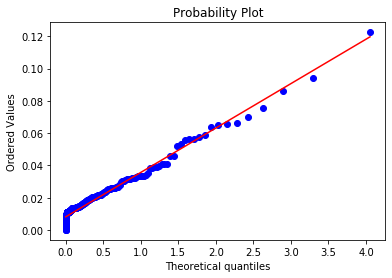

In [888]:
probplot(skill_trends[1].loc[skill_trends[1].Acceleration > 0].Acceleration.values, dist=stats.gamma, 
         sparams=(.3), fit=True, plot=plt)
plt.show()

The acceleration is a Gamma if we remove the very extreme outliers, but with _extremely low_ shape parameters.

((array([1.25872199e-32, 8.93609453e-29, 9.48406085e-27, ...,
         2.58908578e+00, 2.95898131e+00, 3.68341721e+00]),
  array([   1,    1,    1, ..., 5290, 5316, 7007])),
 (1902.9077669547485, 29.714987997810482, 0.9975883055328315))

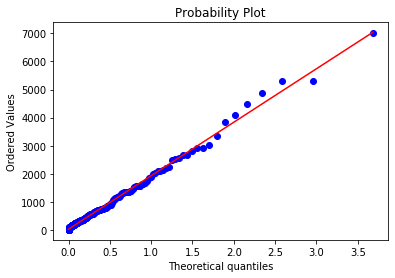

In [889]:
probplot(skills_df[['Skill', 'Job Postings Raw']].groupby('Skill').sum()['Job Postings Raw'].values, 
         dist=stats.gamma, 
         sparams=(.1), fit=True, plot=plt)

## Exported list of skills

In [2380]:
df_export, set_export = get_skills_by_threshold(skill_trends[5], total_values[5], 'HybridScore', [.9,.8,.7], 
                                       [0.001], [0.005, 0.01, 0.02])

In [2381]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(df_export)

,Skill,Slope,Intercept,Acceleration,Spikiness,Job Postings Raw,HybridScore,Params,Set#
0,adobe illustrator,-0.217787,2.703458,0.019715,2.788525,515,0.462840,"(0.9, 0.001, 0.02)",3
1,xml,0.339002,1.397222,0.002053,2.479621,542,0.443853,"(0.9, 0.001, 0.02)",3
2,translation,0.316275,0.746395,0.003729,2.482833,563,0.454695,"(0.9, 0.001, 0.02)",3
3,test automation,0.352899,-1.102050,0.001620,2.867553,438,0.442881,"(0.9, 0.001, 0.02)",3
4,tableau,0.087389,1.090091,0.008387,2.280203,507,0.442977,"(0.9, 0.001, 0.02)",3
5,spring framework,-0.078089,2.045224,0.012176,2.784338,433,0.435099,"(0.9, 0.001, 0.02)",3
6,root cause analysis,0.040120,1.048991,0.009018,2.707316,418,0.436926,"(0.9, 0.001, 0.02)",3
7,relational database,0.048386,0.233972,0.011297,3.116677,442,0.459549,"(0.9, 0.001, 0.02)",3
8,node.js,0.164557,0.734577,0.008934,2.738612,525,0.466978,"(0.9, 0.001, 0.02)",3
9,unit testing,0.269707,0.210680,0.006045,2.788500,579,0.465612,"(0.9, 0.001, 0.02)",3


How would our method distinguish between skills that seem emerging in _this market_ vis a vis the skills that are _globally_ emerging? I think we can't do that unless we have some data on that global market (so basically it'd be great if we could have BGT back, I guess).

In [2369]:
total_values[5] * 0.02

631.74

In [2366]:
skill_trends[5].loc[skill_trends[5]['Job Postings Raw'] > total_values[5] * 0.02]

,Slope,Intercept,Acceleration,Spikiness,Job Postings Raw,HybridScore
Skill,,,,,,
.net,-0.266247,11.619341,0.024426,2.122196,1307,0.488084
account management,1.574254,-1.229876,-0.012964,1.918817,1678,0.539796
adobe photoshop,-0.319392,6.168371,0.023765,2.431678,740,0.468202
amazon web services,0.408589,1.918473,0.018218,2.387861,1340,0.606052
android,-0.258916,7.695582,0.018900,2.451865,823,0.444928
angularjs,0.137890,2.195722,0.010186,2.420166,651,0.471806
artificial intelligence,-0.317461,3.985162,0.028390,2.388737,825,0.505208
autodesk,0.185757,-0.273379,-0.001377,2.268759,667,0.373411
big data,0.344219,1.760554,0.008723,2.468648,862,0.507938


## Analysis with companies

In [2419]:
len(skills_df.Company.unique())

2300

In [2404]:
def get_all_related_companies(df, company_list):
    results = list()
    for company in company_list:
        results.extend(df.loc[df.Company.apply(lambda x: company.lower() in x.lower())].\
                                               Company.unique().tolist())
    return results

In [2423]:
company_totals[['Company', 'Total']].groupby('Company').sum().\
                                sort_values('Total', ascending=False).head(30)

,Total
Company,
ST Electronics (Info-comm Systems) Pte Ltd,1831
Facebook,1363
IHIS - Integrated Health Information Systems Pte Ltd,944
Cisco Systems,786
Autodesk,756
GOOGLE ASIA PACIFIC PTE. LTD.,666
VMware,505
M1 Limited,455
Amadeus IT Group SA,453


In [2430]:
#set_of_companies = get_all_related_companies(skills_df, ['Amazon', 'Google', 'Microsoft', 'Facebook'])
set_of_companies = company_totals[['Company', 'Total']].groupby('Company').sum().\
                                sort_values('Total', ascending=False).head(10).index.values.tolist()

companies_skills = get_set_of_companies(skills_df, set_of_companies)
companies_specialised_skill_trends = [logsum_trend_slope_wrapper(companies_skills, 
                                                  start_and_end_dates[i][0], start_and_end_dates[i][1],
                                                  compute_total_log_mean(
                                              companies_skills)) 
                                      for i in range(len(start_and_end_dates))]

Start: 2017-01-01
End: 2018-01-01
Number of skills: 386
            Slope   Intercept  Acceleration   Spikiness
count  386.000000  386.000000    386.000000  386.000000
mean    -0.110501   -2.157410      0.015372    0.621733
std      0.219720    1.034200      0.019715    2.860143
min     -1.282896   -3.074474     -0.036381  -38.323774
25%     -0.152281   -2.781346      0.006760    0.739347
50%     -0.069951   -2.550878      0.011059    0.852405
75%     -0.031122   -1.943881      0.018480    0.875239
max      0.793505    2.744127      0.123242   22.003695
Start: 2018-01-01
End: 2019-01-01
Number of skills: 587
            Slope   Intercept  Acceleration   Spikiness
count  587.000000  587.000000    587.000000  587.000000
mean    -0.023653   -1.654006      0.003690    0.667016
std      0.270068    2.047989      0.021091    4.175528
min     -1.299807   -4.200185     -0.079144  -82.018674
25%     -0.129472   -2.683669     -0.001464    0.646934
50%     -0.040380   -2.379401      0.004203    0

In [2431]:
for skill_trend_df in companies_specialised_skill_trends:
    skill_trend_df['HybridScore'] = get_hybrid_score(skill_trend_df, 
                                 ['Slope', 'Acceleration'], weights=[1,1])

In [2432]:
companies_emerging_spec_skills = [threshold_logsum_trends_simple(
        companies_specialised_skill_trends[i], col='HybridScore', 
              only_positives=True,
              col_percentile_thresh=.75, pop_lower=0.001, pop_upper=0.01,
        total=get_period_of_time(compute_total_values(companies_skills),
        start_and_end_dates[i][0], start_and_end_dates[i][1]).sum()[0])
                        for i in range(len(companies_specialised_skill_trends))]

In [2438]:
[compute_prec_recall(companies_emerging_spec_skills[i], emerging_skills[i]) 
                     for i in range(len(companies_emerging_spec_skills))]

{'platform-as-a-service (paas)', 'ibm websphere', 'oracle database', 'enterprise systems', 'xsl', 'vsphere', 'esx', 'benchmarking', 'jboss', 'storage area network', 'soapui', 'solution design'}
12 29 88
{'vb', 'financial analysis', 'bgp (border gateway protocol)', 'shell scripts', 'swift', 'microsoft project', 'mobile technology', 'predictive modelling', 'objective c', 'spss', 'apache kafka', 'matlab', 'google analytics', 'ansible', 'it operations management (itom)', 'gamification', 'blockchain technology', 'data structure', 'interaction design (ixd)', 'enterprise web architecture', 'micro-services', 'scala', 'dynamic host configuration protocol', 'google ads', 'social media (whatsapp)', 'elk stack', 'hris', 'natural language processing (nlp)', 'cryptocurrency', 'github', 'infrastructure-as-a-service (iaas)', 'powershell', 'service management', 'adobe phonegap', 'wireframes'}
35 71 97
{'computer vision', 'oracle database', 'parallel programming', 'waterfall model', 'anti-virus programm

[(0.41379310344827586, 0.13636363636363635, 0.2051282051282051),
 (0.49295774647887325, 0.36082474226804123, 0.41666666666666663),
 (0.3125, 0.18867924528301888, 0.23529411764705885),
 (0.43333333333333335, 0.38235294117647056, 0.40625),
 (0.5428571428571428, 0.18811881188118812, 0.27941176470588236),
 (0.5416666666666666, 0.25, 0.34210526315789475)]